In [4]:
import os
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
 
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=[32,64, 128, 256]):
        super(UNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

        # Down part of UNet
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNet
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature * 2, feature))

        self.bottom = DoubleConv(features[-1], features[-1] * 2)
        self.final = nn.Sequential(
            nn.Conv2d(features[0], out_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottom(x)
        skip_connections = skip_connections[::-1]

        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)
            skip_connection = skip_connections[i // 2]

            #if x.shape != skip_connection.shape:
            #    x = F.interpolate(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[i + 1](concat_skip)

        return self.final(x)



In [2]:
def load_images(blur_dir, sharp_dir):
    blur = []  # Renamed from blur_images to blur
    sharp_images = []
    if not os.listdir(blur_dir):
        print("Blur images folder is empty. Please check your data directories.")
        return [], []

    for sharp_file_name in os.listdir(sharp_dir):
        sharp_path = os.path.join(sharp_dir, sharp_file_name)
        if os.path.isfile(sharp_path):
            if sharp_file_name.endswith('.JPG') or sharp_file_name.endswith('.jpg'):
                blur_base_name = sharp_file_name[:-5] 
                blur_file_name = blur_base_name + 'M.jpg' 
            else:
                blur_base_name = sharp_file_name[:-6]  
                blur_file_name = blur_base_name + 'M.jpeg' 
     
            blur_path = os.path.join(blur_dir, blur_file_name)
            if os.path.isfile(blur_path):
                blur_image = Image.open(blur_path)
                sharp_image = Image.open(sharp_path)
                blur.append(blur_image)
                sharp_images.append(sharp_image)
            else:
                print(f"No corresponding blur image found for sharp image: {sharp_file_name}")
    return blur, sharp_images

In [5]:
class ImageDataset(Dataset):
    def __init__(self, blur_images, sharp_images, transform=None):
        self.blur_images = blur_images
        self.sharp_images = sharp_images
        self.transform = transform
    def __len__(self):
        return len(self.blur_images)
    def __getitem__(self, idx):
        blur_image = self.blur_images[idx]
        sharp_image = self.sharp_images[idx]
        if self.transform:
            blur_image = self.transform(blur_image)
            sharp_image = self.transform(sharp_image)
        return blur_image, sharp_image

In [6]:
blur_dir = 'C:/Users/tusha/Downloads/blur_dataset/blur_dataset/motion_blurred'
sharp_dir = 'C:/Users/tusha/Downloads/blur_dataset/blur_dataset/sharp'

In [7]:
blur_images, sharp_images = load_images(blur_dir, sharp_dir)


In [8]:
blur_train, blur_test, sharp_train, sharp_test = train_test_split(blur_images, sharp_images, test_size=0.3, random_state=42)

In [9]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [10]:
train_dataset = ImageDataset(blur_train, sharp_train, transform=transform)
test_dataset = ImageDataset(blur_test, sharp_test, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False)

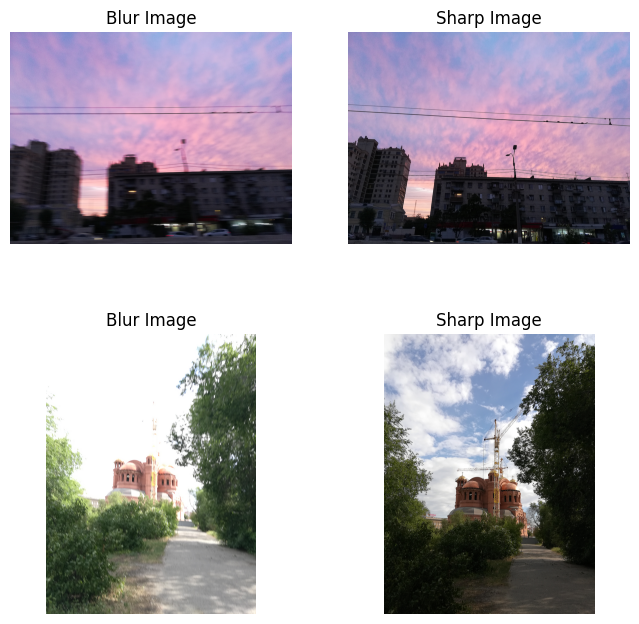

In [11]:
import matplotlib.pyplot as plt
def visualize_sample(dataloader):
    blur, sharp = next(iter(dataloader))
    blur = blur.permute(0, 2, 3, 1).numpy()
    sharp = sharp.permute(0, 2, 3, 1).numpy()

    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    axs[0, 0].imshow(blur_images[10])
    axs[0, 0].set_title("Blur Image")
    axs[0, 1].imshow(sharp_images[10])
    axs[0, 1].set_title("Sharp Image")
    axs[1, 0].imshow(blur_images[20])
    axs[1, 0].set_title("Blur Image")
    axs[1, 1].imshow(sharp_images[20])
    axs[1, 1].set_title("Sharp Image")

    for ax in axs.flat:
        ax.axis('off')

    plt.show()

visualize_sample(train_dataloader)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3, out_channels=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss() 
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for blur_img, sharp_img in train_dataloader:
        blur_img = blur_img.to(device)
        sharp_img = sharp_img.to(device)

        optimizer.zero_grad()
        preds = model(blur_img)
        loss = criterion(preds, sharp_img)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()

    train_loss /= len(train_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}")
    

Epoch 1/3, Train Loss: 0.05530396418842843
Epoch 2/3, Train Loss: 0.04973058920444512
Epoch 3/3, Train Loss: 0.04841483054243452


In [13]:
torch.save(model.state_dict(), 'best_model.pth')
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

to_pil = transforms.ToPILImage()
output_dir = 'predicted_images'
os.makedirs(output_dir, exist_ok=True)

with torch.no_grad():
    for idx, (blur_img, _) in enumerate(test_dataloader):
        blur_img = blur_img.to(device)
        pred = model(blur_img)
        pred = pred.cpu()

        for i in range(pred.size(0)):
            pred_img = to_pil(pred[i])
            pred_img.save(os.path.join(output_dir, f'predicted_image_{idx * pred.size(0) + i + 1}.jpg'))

print(f'Predicted images saved to {output_dir}')

Predicted images saved to predicted_images
